In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download abdallahwagih/retina-blood-vessel

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
 15% 5.00M/32.9M [00:00<00:00, 30.3MB/s]
100% 32.9M/32.9M [00:00<00:00, 135MB/s] 


In [7]:
! unzip /content/retina-blood-vessel.zip

Archive:  /content/retina-blood-vessel.zip
  inflating: Data/test/image/0.png   
  inflating: Data/test/image/1.png   
  inflating: Data/test/image/10.png  
  inflating: Data/test/image/11.png  
  inflating: Data/test/image/12.png  
  inflating: Data/test/image/13.png  
  inflating: Data/test/image/14.png  
  inflating: Data/test/image/15.png  
  inflating: Data/test/image/16.png  
  inflating: Data/test/image/17.png  
  inflating: Data/test/image/18.png  
  inflating: Data/test/image/19.png  
  inflating: Data/test/image/2.png   
  inflating: Data/test/image/3.png   
  inflating: Data/test/image/4.png   
  inflating: Data/test/image/5.png   
  inflating: Data/test/image/6.png   
  inflating: Data/test/image/7.png   
  inflating: Data/test/image/8.png   
  inflating: Data/test/image/9.png   
  inflating: Data/test/mask/0.png    
  inflating: Data/test/mask/1.png    
  inflating: Data/test/mask/10.png   
  inflating: Data/test/mask/11.png   
  inflating: Data/test/mask/12.png   
  infla

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Conv2DTranspose,Activation,concatenate,Input
from tensorflow.keras import Sequential,Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

U NET

In [10]:
def conv_block(input,filters):
    x = Conv2D(filters,3,padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input,filters):

    x = conv_block(input,filters)
    p = MaxPooling2D((2,2))(x)
    return x,p

def decoder_block(input,skip,filters):

    x = Conv2DTranspose(filters,2,strides=2,padding="same")(input)
    x = concatenate([x,skip])
    x = conv_block(x,filters)
    return x

In [11]:
def build_model():
    input = Input(shape=(512,512,3))

    x1,p1 = encoder_block(input,64)
    x2,p2 = encoder_block(p1,128)
    p2 = Dropout(0.2)(p2)
    x3,p3 = encoder_block(p2,256)
    x4,p4 = encoder_block(p3,512)
    p4 = Dropout(0.2)(p4)

    a1 = conv_block(p4,1024)

    d1 = decoder_block(a1,x4,512)
    d2 = decoder_block(d1,x3,256)
    d3 = decoder_block(d2,x2,128)
    d4 = decoder_block(d3,x1,64)

    output = Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
    model = Model(input,output)
    return model

In [12]:
def load_data(path,img_size):
    images = []
    masks = []
    for img_files,mask_files in zip(os.listdir(path+"/image"),os.listdir(path+"/mask")):
        img_path = os.path.join(path+"/image",img_files)
        mask_path = os.path.join(path+"/mask",mask_files)

        img = load_img(img_path,target_size=img_size)
        mask = load_img(mask_path,target_size=img_size,color_mode="grayscale")

        img = img_to_array(img)/255.0
        mask = img_to_array(mask)/255.0

        images.append(img)
        masks.append(mask)
    return np.array(images),np.array(masks)

In [13]:
x_train,y_train = load_data("/content/Data/train",(512,512))
x_test,y_test = load_data("/content/Data/test",(512,512))
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((80, 512, 512, 3), (80, 512, 512, 1), (20, 512, 512, 3), (20, 512, 512, 1))

In [15]:
#since very less data is available use augmentation tech to increase data size

def augment_image(image, mask):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, mask

In [16]:
def tf_dataset(x,y,batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=8)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(x_train,y_train,batch_size=8)
test_dataset = tf_dataset(x_test,y_test,batch_size=8)

In [17]:
model = build_model()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [18]:
history = model.fit(train_dataset,
                    epochs=100,
                    batch_size=8,
                    validation_data=test_dataset,
                    )

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.7391 - loss: 0.5271 - val_accuracy: 0.2058 - val_loss: 5.4280
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8779 - loss: 0.2912 - val_accuracy: 0.2139 - val_loss: 298.7645
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8786 - loss: 0.2735 - val_accuracy: 0.1119 - val_loss: 42.1005
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8786 - loss: 0.2682 - val_accuracy: 0.1865 - val_loss: 8.3935
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8781 - loss: 0.2666 - val_accuracy: 0.3336 - val_loss: 2.2614
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8782 - loss: 0.2643 - val_accuracy: 0.7864 - val_loss: 0.5244
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8778 - loss: 0.2633 - val_accuracy: 0.7739 - val_loss: 0.5035
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8785 - loss: 0.2615 - val_accuracy: 0.8696

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


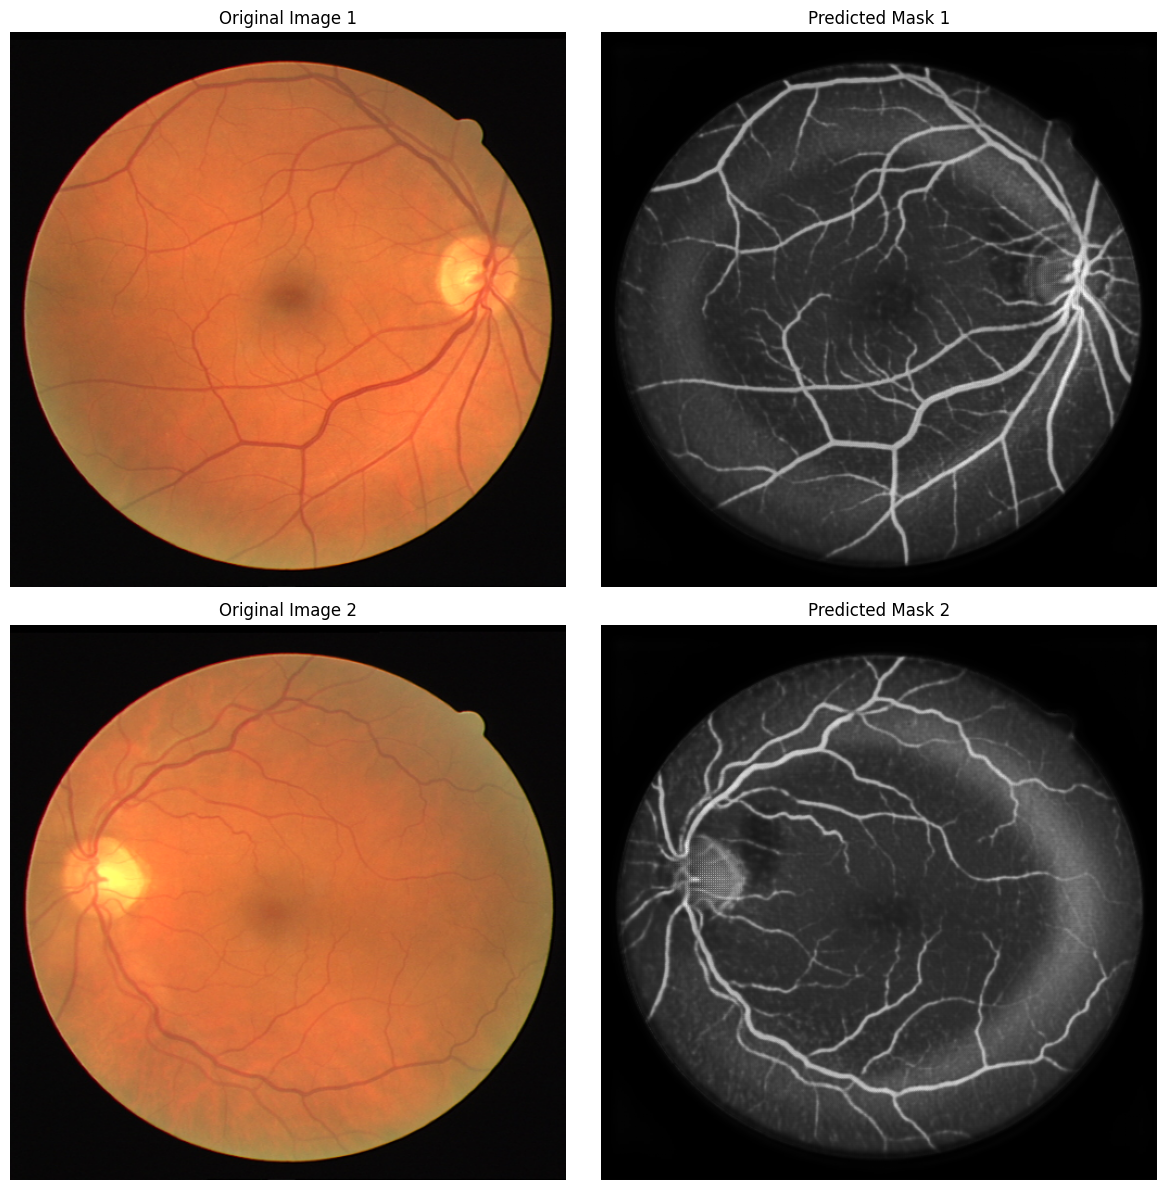

In [19]:
img_paths = ["/content/Data/test/image/15.png",
             "/content/Data/test/image/8.png"]

plt.figure(figsize=(12, 12))

for i, img_path in enumerate(img_paths):
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    prediction_mask = np.squeeze(prediction)


    plt.subplot(2, 2, 2*i + 1)
    plt.imshow(img_array[0])
    plt.axis('off')
    plt.title(f'Original Image {i + 1}')

    plt.subplot(2, 2, 2*i + 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted Mask {i + 1}')

plt.tight_layout()
plt.show()

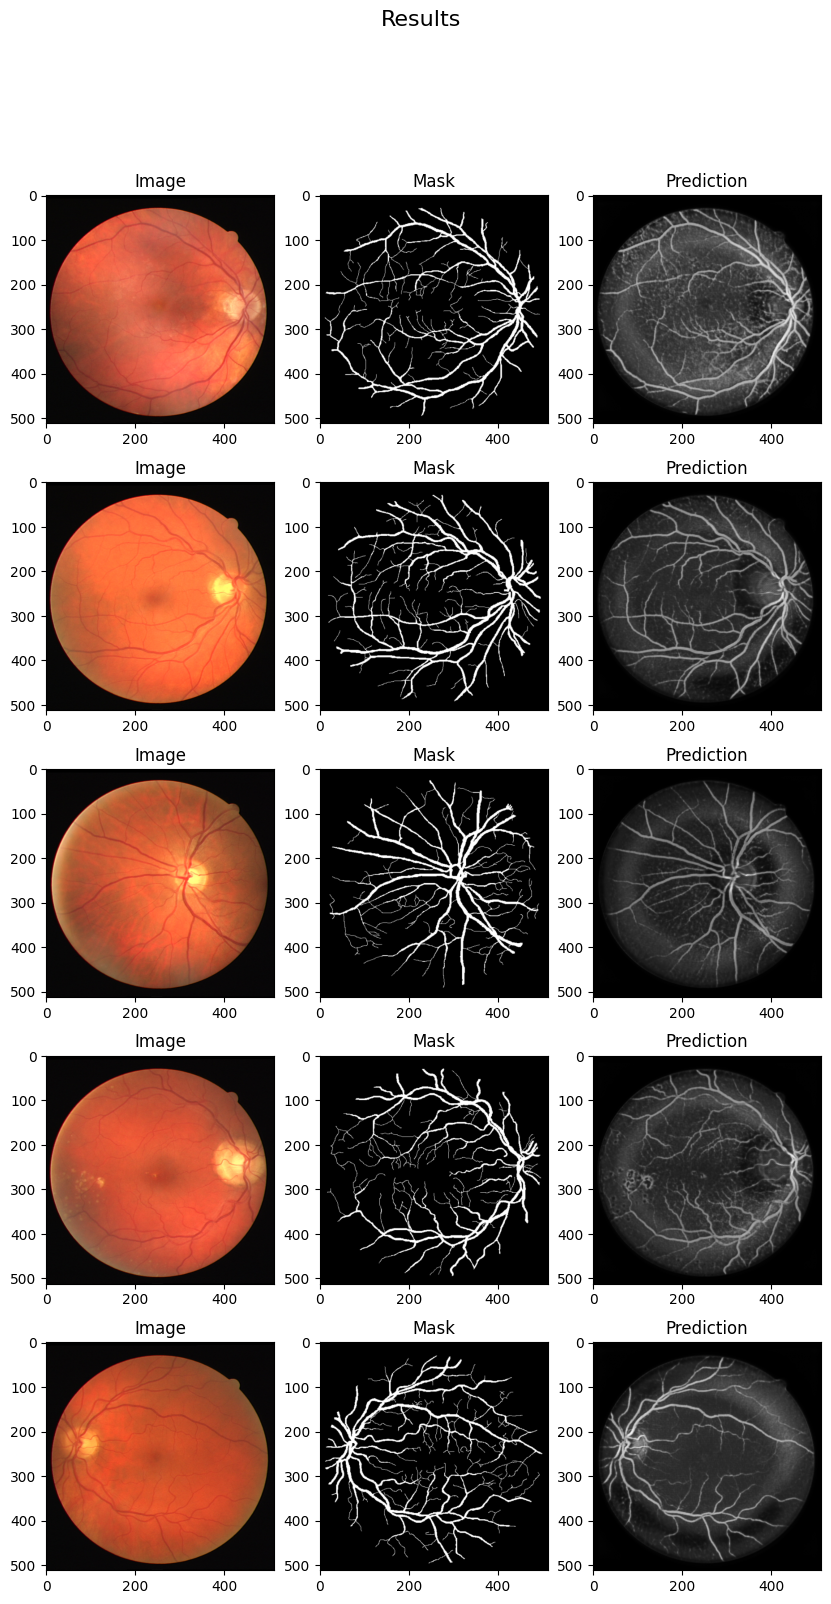

In [21]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

test_images = x_test
test_masks = y_test


j = np.random.randint(0,test_images.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(test_images[j[i]])
    ax[i,0].set_title('Image')
    ax[i,1].imshow(test_masks[j[i]],cmap='gray')
    ax[i,1].set_title('Mask')
    y_hat = model.predict(np.expand_dims(test_images[j[i]],0),verbose=0)[0]

    binary_mask =  np.squeeze(y_hat)
    ax[i,2].imshow(binary_mask,cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()